# Methods definition

In [1]:
import re
import networkx as nx
import argparse
import traceback
import matplotlib.pyplot as plt
import os
import torch
from torch_geometric.data import Data
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

# Global variables
node_scaler = None
edge_scaler = None
last_update_time = None
update_interval = 3600  # seconds (e.g., 1 hour)

def dot_to_nx(dot_file):
    """
    Parses a .dot file representing a  graph and returns a NetworkX MultiDiGraph.
    Handles node and edge attributes.

    Args:
        dot_file (str): Path to the .dot file.

    Returns:
        networkx.MultiDiGraph: A NetworkX MultiDiGraph object.
    """
    graph = nx.MultiDiGraph()

    with open(dot_file, 'r') as f:
        content = f.read()

    # Extract node information
    node_pattern = re.compile(r'^\s*"([^"]+)"\s*\[(.*?)\];\s*$', re.MULTILINE)
    for match in node_pattern.finditer(content):
        node_id = match.group(1)
        attributes_str = match.group(2).strip()
        attributes = {}
        for attr in attributes_str.split(','):
            if '=' in attr:
                key, value = attr.split('=', 1)
                key = key.strip()
                value = value.strip().strip('"')
                try:
                    attributes[key] = float(value)
                except ValueError:
                    attributes[key] = value
            else:
                print(f"Warning: Skipping malformed node attribute: '{attr}' in node '{node_id}'")
        graph.add_node(node_id, **attributes)

    # Extract edge information
    edge_pattern = re.compile(r'"([^"]+)" -> "([^"]+)" \[(.*?)\];')
    for match in edge_pattern.finditer(content):
        source, target = match.group(1), match.group(2)
        attributes_str = match.group(3).strip()
        attributes = {}
        if attributes_str:
            for attr in attributes_str.split(','):
                if '=' in attr:
                    key, value = attr.split('=', 1)
                    key = key.strip()
                    value = value.strip().strip('"')
                    try:
                        attributes[key] = float(value)
                    except ValueError:
                        attributes[key] = value
                else:
                    print(f"Warning: Skipping malformed edge attribute: '{attr}' between '{source}' and '{target}'")
        graph.add_edge(source, target, **attributes)

    return graph


def visualize_nx_graph(nx_graph, layout_algorithm='spring', output_path=None):
    """
    Visualizes a NetworkX graph, handling multiple edges and allowing saving to a file.

    Args:
        nx_graph (networkx.MultiDiGraph): The NetworkX graph to visualize.
        layout_algorithm (str, optional): The layout algorithm to use.
            Defaults to 'spring'.
        output_path (str, optional): Path to save the visualization.
    """
    plt.figure(figsize=(12, 10))

    if layout_algorithm == 'spring':
        pos = nx.spring_layout(nx_graph, k=0.3, iterations=100, seed=42)
    elif layout_algorithm == 'circular':
        pos = nx.circular_layout(nx_graph)
    elif layout_algorithm == 'spectral':
        pos = nx.spectral_layout(nx_graph)
    elif layout_algorithm == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(nx_graph)
    elif layout_algorithm == 'random':
        pos = nx.random_layout(nx_graph)
    else:
        pos = nx.spring_layout(nx_graph)

    # Draw nodes
    nx.draw_networkx_nodes(nx_graph, pos, node_size=1000, node_color="lightblue")
    nx.draw_networkx_labels(nx_graph, pos, font_size=8, font_weight="bold")

    # Draw edges with different styles for multiple edges
    for u, v, k, data in nx_graph.edges(data=True, keys=True):
        if nx_graph.number_of_edges(u, v) > 1:
            # Distinguish parallel edges visually
            if k == 0:
                edge_color = "red"
                style = "solid"
            elif k == 1:
                edge_color = "green"
                style = "dashed"
            elif k == 2:
                edge_color = "blue"
                style = "dotted"
            else:
                edge_color = "gray"
                style = "solid"
            nx.draw_networkx_edges(nx_graph, pos, edgelist=[(u, v)], edge_color=edge_color, style=style, arrows=True)
        else:
            nx.draw_networkx_edges(nx_graph, pos, edgelist=[(u, v)], edge_color="black", style="solid", arrows=True)

    # Add edge labels (show attributes)
    edge_labels = {(u, v): str(d) for u, v, d in nx_graph.edges(data=True)}  # Get all edge attributes
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=6)

    plt.title(f"NetworkX Graph Visualization ({layout_algorithm} Layout)")
    plt.tight_layout()
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        plt.savefig(output_path)
        print(f"Graph saved to {output_path}")
    else:
        plt.show()

    plt.close()

def save_nx_graph(nx_graph, output_path):
    """
    Saves a NetworkX graph to a file.  Uses a format that preserves multiple edges
    and their attributes.

    Args:
        nx_graph (networkx.MultiDiGraph): The NetworkX graph to save.
        output_path (str): Path to save the graph.
    """
    try:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        nx.write_gpickle(nx_graph, output_path)
        print(f"Graph saved to {output_path} in Pickle format")
    except Exception as e:
        print(f"Error saving graph: {e}")
        traceback.print_exc()

def nx_to_pyg(nx_graph, node_scaling='none', edge_scaling='none', fit_scaler=True):
    """
    Converts a NetworkX MultiDiGraph to a PyTorch Geometric Data object,
    extracting features and applying preprocessing, handling online scaling.

    Args:
        nx_graph (networkx.MultiDiGraph): The input NetworkX graph.
        node_scaling (str, optional): Scaling method for node features ('none', 'standard', 'minmax').
            Defaults to 'none'.
        edge_scaling (str, optional): Scaling method for edge features ('none', 'standard', 'minmax').
            Defaults to 'none'.
        fit_scaler (bool, optional): Whether to fit the scalers on the input data.
            Defaults to True.  Set to False for online scaling after initial fitting.

    Returns:
        torch_geometric.data.Data: A PyTorch Geometric Data object.
    """
    global node_scaler, edge_scaler, last_update_time, update_interval

    current_time = datetime.now().timestamp()

    # 1. Determine the complete set of node attributes.
    all_node_attr_keys = set()
    for node in nx_graph.nodes():
        all_node_attr_keys.update(nx_graph.nodes[node].keys())
    sorted_node_attr_keys = sorted(list(all_node_attr_keys))
    print("Sorted node attribute keys:", sorted_node_attr_keys)
    # 2.  Create node features
    node_features = []
    node_ip_addresses = []
    for node in nx_graph.nodes():
        node_ip_addresses.append(node)
        node_feature_list = []
        for key in sorted_node_attr_keys:
            value = nx_graph.nodes[node].get(key)
            if isinstance(value, (int, float)):
                node_feature_list.append(value)
            else:
                node_feature_list.append(0.0)
        node_features.append(node_feature_list)
    x = torch.tensor(node_features, dtype=torch.float)

    # 3. Apply Node Feature Scaling
    if node_scaling == 'standard':
        if fit_scaler or node_scaler is None or (last_update_time is not None and (current_time - last_update_time) > update_interval):
            node_scaler = StandardScaler()
            x = torch.tensor(node_scaler.fit_transform(x), dtype=torch.float)
            if fit_scaler:
                print("Node Features (x) after initial standard scaling:", x)
            else:
                print("Node Features (x) after periodic standard scaling:", x)
            last_update_time = current_time  # update last_update_time
        elif node_scaler is not None:
            x = torch.tensor(node_scaler.transform(x), dtype=torch.float)
            print("Node Features (x) after online standard scaling:", x)
        else:
            print("No node scaler fitted. Skipping scaling.")
    elif node_scaling == 'minmax':
        if fit_scaler or node_scaler is None or (last_update_time is not None and (current_time - last_update_time) > update_interval):
            node_scaler = MinMaxScaler()
            x = torch.tensor(node_scaler.fit_transform(x), dtype=torch.float)
            if fit_scaler:
                print("Node Features (x) after initial min-max scaling:", x)
            else:
                print("Node Features (x) after periodic min-max scaling:", x)
            last_update_time = current_time
        elif node_scaler is not None:
            x = torch.tensor(node_scaler.transform(x), dtype=torch.float)
            print("Node Features (x) after online min-max scaling:", x)
        else:
            print("No node scaler fitted. Skipping scaling.")
    elif node_scaling == 'none':
        print("No node feature scaling applied.")
    else:
        raise ValueError(f"Invalid node_scaling method: {node_scaling}.  Choose 'none', 'standard', or 'minmax'.")

    # Edge indices
    edge_index = torch.tensor(
        [[list(nx_graph.nodes).index(u), list(nx_graph.nodes).index(v)] for u, v in nx_graph.edges()],
        dtype=torch.long
    ).t().contiguous()

    # Edge attributes
    edge_features = []
    edge_attr_keys = set()
    for u, v, data in nx_graph.edges(data=True):
        edge_attr_keys.update(data.keys())
    sorted_edge_attr_keys = sorted(list(edge_attr_keys))
    print("Sorted edge attribute keys:", sorted_edge_attr_keys) # print the sorted keys
    for u, v, data in nx_graph.edges(data=True):
        edge_feature_list = []
        for key in sorted_edge_attr_keys:
            value = data.get(key)
            if isinstance(value, (int, float)):
                edge_feature_list.append(value)
            else:
                edge_feature_list.append(0.0)
        edge_features.append(edge_feature_list)

    edge_attr = torch.tensor(edge_features, dtype=torch.float) if edge_features else None

    # 4. Apply Edge Feature Scaling
    if edge_attr is not None:
        if edge_scaling == 'standard':
            if fit_scaler or edge_scaler is None or (last_update_time is not None and (current_time - last_update_time) > update_interval):
                edge_scaler = StandardScaler()
                edge_attr = torch.tensor(edge_scaler.fit_transform(edge_attr), dtype=torch.float)
                if fit_scaler:
                    print("Edge Attributes (edge_attr) after initial standard scaling:", edge_attr)
                else:
                    print("Edge Attributes (edge_attr) after periodic standard scaling:", edge_attr)
            elif edge_scaler is not None:
                edge_attr = torch.tensor(edge_scaler.transform(edge_attr), dtype=torch.float)
                print("Edge Attributes (edge_attr) after online standard scaling:", edge_attr)
            else:
                print("No edge scaler fitted. Skipping scaling")
        elif edge_scaling == 'minmax':
            if fit_scaler or edge_scaler is None or (last_update_time is not None and (current_time - last_update_time) > update_interval):
                edge_scaler = MinMaxScaler()
                edge_attr = torch.tensor(edge_scaler.fit_transform(edge_attr), dtype=torch.float)
                if fit_scaler:
                    print("Edge Attributes (edge_attr) after initial min-max scaling:", edge_attr)
                else:
                    print("Edge Attributes (edge_attr) after periodic min-max scaling:", edge_attr)
            elif edge_scaler is not None:
                edge_attr = torch.tensor(edge_scaler.transform(edge_attr), dtype=torch.float)
                print("Edge Attributes (edge_attr) after online min-max scaling:", edge_attr)
            else:
                print("No edge scaler fitted. Skipping scaling.")
        elif edge_scaling == 'none':
            print("No edge feature scaling applied.")
        else:
            raise ValueError(f"Invalid edge_scaling method: {edge_scaling}.  Choose 'none', 'standard', or 'minmax'.")

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data


def update_nx_graph(nx_graph, update_dot_file):
    """
    Updates a NetworkX graph with the changes from an update .dot file.
    Handles adding, modifying, and deleting nodes and edges.  Assumes the
    update_dot_file contains only the *changes* to the graph.

    Args:
        nx_graph (networkx.MultiDiGraph): The original NetworkX graph to update.
        update_dot_file (str): Path to the .dot file containing the updates.
    """
    update_graph = dot_to_nx(update_dot_file)  # Use the existing dot_to_nx function

    # 1. Update or add nodes
    for node_id in update_graph.nodes():
        if nx_graph.has_node(node_id):
            # Update existing node attributes
            for key, value in update_graph.nodes[node_id].items():
                nx_graph.nodes[node_id][key] = value
            print(f"Updated node: {node_id}")
        else:
            # Add new node with attributes
            nx_graph.add_node(node_id, **update_graph.nodes[node_id])
            print(f"Added node: {node_id}")

    # 2. Update or add edges
    for u, v, key, data in update_graph.edges(data=True, keys=True):
        """
        if nx_graph.has_edge(u, v, key):
            # Update existing edge attributes
            for key_attr, value in data.items():
                nx_graph.edges[u, v, key][key_attr] = value
            print(f"Updated edge: {u} -> {v}, key={key}")
        else:
        """
        # Add new edge with attributes.  Important:  Check if the nodes exist.
        if not nx_graph.has_node(u):
            nx_graph.add_node(u)  # Add the node if it doesn't exist
            print(f"Added missing node {u} during edge update.")
        if not nx_graph.has_node(v):
            nx_graph.add_node(v)  # Add the node if it doesn't exist
            print(f"Added missing node {v} during edge update.")
        nx_graph.add_edge(u, v, key=key, **data)
        print(f"Added edge: {u} -> {v}, key={key}")
    """
    # 3. Handle Deletions (Nodes and Edges) - This is CRUCIAL for correct updates
    # Identify nodes to delete (nodes in original graph but not in update graph)
    nodes_to_delete = [node_id for node_id in nx_graph.nodes() if not update_graph.has_node(node_id)]
    for node_id in nodes_to_delete:
        nx_graph.remove_node(node_id)
        print(f"Deleted node: {node_id}")

    # Identify edges to delete (more complex because of keys)
    edges_to_delete = []
    for u, v, key in nx_graph.edges(keys=True):
        if not update_graph.has_edge(u, v, key):
            edges_to_delete.append((u, v, key))
    for u, v, key in edges_to_delete:
        nx_graph.remove_edge(u, v, key=key)
        print(f"Deleted edge: {u} -> {v}, key={key}")
    """
    return nx_graph


In [2]:
import numpy as np


def visualize_edge_features(data: Data, edge_feature_names: list = None, max_features_to_plot=12):
    """
    Visualizza le edge features con tecniche per gestire molte feature

    Args:
        data: PyTorch Geometric Data object
        edge_feature_names: Lista di nomi per le edge features
        max_features_to_plot: Numero massimo di feature da visualizzare
    """
    if not hasattr(data, 'edge_attr') or data.edge_attr is None:
        print("Nessuna edge feature trovata nel grafo.")
        return

    edge_features = data.edge_attr.numpy() if data.edge_attr.is_cuda else data.edge_attr.detach().numpy()
    num_edges, num_features = edge_features.shape

    # Nomi delle feature
    if edge_feature_names is not None:
        if len(edge_feature_names) != num_features:
            raise ValueError(f"Attesi {num_features} nomi, ottenuti {len(edge_feature_names)}")
        use_names = edge_feature_names
    else:
        use_names = [f'EdgeFeat_{i}' for i in range(num_features)]

    print(f"Grafo con {num_edges} archi e {num_features} edge features:")

    # Calcolo statistiche rapide
    print("\nStatistiche edge features:")
    stats = []
    for i in range(num_features):
        unique_vals = np.unique(edge_features[:, i])
        stats.append({
            'name': use_names[i],
            'unique': len(unique_vals),
            'mean': np.mean(edge_features[:, i]),
            'std': np.std(edge_features[:, i]),
            'min': np.min(edge_features[:, i]),
            'max': np.max(edge_features[:, i])
        })

    # Stampiamo solo le prime e ultime 5 feature per non inondare l'output
    for stat in stats[:5] + stats[-5:]:
        print(f"- {stat['name']}: {stat}")
    if num_features > 10:
        print(f"\n... omesse {num_features-10} features intermedie ...")

    # Creazione figura con layout ottimizzato per molte feature
    plt.figure(figsize=(20, 15))
    plt.suptitle(f'Analisi Edge Features ({num_features} totali)', y=1.02, fontsize=16)

    # 1. Heatmap delle prime N feature (per vedere pattern)
    plt.subplot(3, 2, 1)
    features_to_show = min(max_features_to_plot, num_features)
    sns.heatmap(edge_features[:, :features_to_show].T,
                cmap='viridis',
                yticklabels=use_names[:features_to_show],
                cbar_kws={'label': 'Valore feature'})
    plt.title(f'Heatmap Prime {features_to_show} Edge Features')
    plt.xlabel('Archi')
    plt.ylabel('Feature')

    # 2. Matrice di correlazione (solo per feature non costanti)
    plt.subplot(3, 2, 2)
    non_constant_features = [i for i in range(num_features) if stats[i]['unique'] > 1]
    if len(non_constant_features) > 1:
        corr = np.corrcoef(edge_features[:, non_constant_features].T)
        sns.heatmap(corr,
                    cmap='coolwarm',
                    center=0,
                    xticklabels=[use_names[i] for i in non_constant_features],
                    yticklabels=[use_names[i] for i in non_constant_features],
                    annot=False)
        plt.title('Matrice di Correlazione\n(Solo feature non costanti)')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
    else:
        plt.text(0.5, 0.5, 'Troppe feature costanti\nper la matrice di correlazione',
               ha='center', va='center')
        plt.axis('off')

    # 3. Distribuzioni delle feature più interessanti
    plt.subplot(3, 2, 3)

    # Seleziona le feature più informative (basato su deviazione standard)
    stds = [s['std'] for s in stats]
    if np.sum(stds) > 0:  # Se almeno una feature non è costante
        # Prendiamo le feature con deviazione standard più alta
        most_variable = np.argsort(stds)[-max_features_to_plot:]

        for i in most_variable:
            if stats[i]['unique'] > 1:  # Solo feature non costanti
                # Normalizziamo per visualizzare insieme
                feat = edge_features[:, i]
                if stats[i]['unique'] > 10:  # Feature continua
                    sns.kdeplot(feat, label=use_names[i], bw_method=0.3)
                else:  # Feature discreta
                    sns.histplot(feat, label=use_names[i], discrete=True)

        plt.title(f'Distribuzioni Feature più Variabili\n({max_features_to_plot} su {num_features})')
        plt.xlabel('Valore normalizzato')
        plt.ylabel('Densità')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Tutte le feature sono costanti!',
               ha='center', va='center')
        plt.axis('off')

    # 4. Boxplot delle feature più importanti
    plt.subplot(3, 2, 4)
    if len(non_constant_features) > 0:
        features_to_boxplot = non_constant_features[:max_features_to_plot]
        boxplot_data = edge_features[:, features_to_boxplot]

        # Normalizzazione per rendere i boxplot comparabili
        boxplot_data = (boxplot_data - np.mean(boxplot_data, axis=0)) / (np.std(boxplot_data, axis=0) + 1e-8)

        sns.boxplot(data=pd.DataFrame(boxplot_data,
                                    columns=[use_names[i] for i in features_to_boxplot]))
        plt.title(f'Boxplot Feature non Costanti\n(Normalizzate, prime {len(features_to_boxplot)})')
        plt.xticks(rotation=90)
        plt.ylabel('Valori normalizzati')
    else:
        plt.text(0.5, 0.5, 'Nessuna feature non costante\nper il boxplot',
               ha='center', va='center')
        plt.axis('off')

    # 5. Analisi sparsità
    plt.subplot(3, 2, 5)
    sparsity = np.mean(edge_features == 0, axis=0)
    plt.bar(range(num_features), sparsity)
    plt.xticks(range(num_features), use_names, rotation=90)
    plt.title('Sparsità Edge Features\n(Frazione di zeri)')
    plt.ylabel('Frazione di zeri')
    plt.axhline(np.mean(sparsity), color='r', linestyle='--',
               label=f'Media: {np.mean(sparsity):.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 6. PCA per riduzione dimensionalità (se molte feature)
    plt.subplot(3, 2, 6)
    if len(non_constant_features) > 3:
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler

        # Prendiamo solo feature non costanti
        X = edge_features[:, non_constant_features]
        X = StandardScaler().fit_transform(X)

        # PCA con 2 componenti
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(X)

        plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
        plt.title('Riduzione Dimensionalità (PCA)\nSpiegato: {:.1f}%'.format(100*pca.explained_variance_ratio_.sum()))
        plt.xlabel('Prima Componente ({:.1f}%)'.format(100*pca.explained_variance_ratio_[0]))
        plt.ylabel('Seconda Componente ({:.1f}%)'.format(100*pca.explained_variance_ratio_[1]))
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Troppe poche feature non costanti\nper PCA',
               ha='center', va='center')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Analisi aggiuntiva
    print("\nAnalisi aggiuntiva:")
    if len(non_constant_features) < num_features:
        print(f"- {num_features - len(non_constant_features)} feature sono costanti")

    if len(non_constant_features) > 1:
        abs_corr = np.abs(corr)
        np.fill_diagonal(abs_corr, 0)
        max_corr = np.max(abs_corr)
        print(f"- Massima correlazione tra feature diverse: {max_corr:.2f}")

        # Trova le feature più correlate
        if max_corr > 0.8:  # Soglia per correlazione alta
            idx = np.unravel_index(np.argmax(abs_corr), abs_corr.shape)
            print(f"- Feature più correlate: {use_names[non_constant_features[idx[0]]]} e "
                 f"{use_names[non_constant_features[idx[1]]]} ({max_corr:.2f})")

In [3]:
import pandas as pd
import seaborn as sns


def visualize_node_features(data: Data, feature_names: list = None):
    """
    Visualizza le feature dei nodi con scale appropriate e layout ottimizzato

    Args:
        data: PyTorch Geometric Data object
        feature_names: Lista di nomi per le feature
    """
    # Estrazione e preparazione dati
    if not hasattr(data, 'x') or data.x is None:
        print("Nessuna feature trovata nel grafo.")
        return

    node_features = data.x.numpy() if data.x.is_cuda else data.x.detach().numpy()
    num_nodes, num_features = node_features.shape

    # Nomi delle feature
    if feature_names is not None:
        if len(feature_names) != num_features:
            raise ValueError(f"Attesi {num_features} nomi, ottenuti {len(feature_names)}")
        use_names = feature_names
    else:
        use_names = [f'Feature {i}' for i in range(num_features)]

    print(f"Grafo con {num_nodes} nodi e {num_features} features:")
    print("Nomi features:", ", ".join(use_names))

    # Calcolo statistiche rapide
    print("\nStatistiche features:")
    stats = []
    for i in range(num_features):
        unique_vals = np.unique(node_features[:, i])
        stats.append({
            'name': use_names[i],
            'unique': len(unique_vals),
            'mean': np.mean(node_features[:, i]),
            'std': np.std(node_features[:, i]),
            'min': np.min(node_features[:, i]),
            'max': np.max(node_features[:, i])
        })
        print(f"- {use_names[i]}: {stats[-1]}")

    # Creazione figura con layout ottimizzato
    plt.figure(figsize=(18, 12))
    plt.suptitle('Analisi Feature dei Nodi', y=1.02, fontsize=16)

    # 1. Distribuzione activity_score (se presente)
    if 'activity_score' in use_names:
        idx = use_names.index('activity_score')
        plt.subplot(2, 3, 1)
        sns.kdeplot(node_features[:, idx], label='activity_score', bw_method=0.15, fill=True)
        plt.title('Distribuzione Activity Score')
        plt.xlabel('Valore')
        plt.ylabel('Densità')
        plt.grid(True, alpha=0.3)

    # 2. Distribuzioni di grado (scala logaritmica)
    degree_features = []
    for name in ['degree', 'in_degree', 'out_degree', 'total_connections']:
        if name in use_names:
            degree_features.append(use_names.index(name))

    if degree_features:
        plt.subplot(2, 3, 2)
        for i in degree_features:
            log_vals = np.log1p(node_features[:, i])
            sns.kdeplot(log_vals, label=use_names[i], bw_method=0.3, fill=True)

        plt.title('Distribuzioni Metriche di Grado\n(scala logaritmica)')
        plt.xlabel('log(valore + 1)')
        plt.ylabel('Densità')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # 3. Boxplot features di grado (log)
    if degree_features:
        plt.subplot(2, 3, 3)
        log_data = np.log1p(node_features[:, degree_features])
        sns.boxplot(data=pd.DataFrame(log_data, columns=[use_names[i] for i in degree_features]))
        plt.title('Confronto Metriche di Grado')
        plt.xticks(rotation=45)
        plt.ylabel('log(valore + 1)')

    # 4. Matrice di correlazione
    plt.subplot(2, 3, 4)
    corr = np.corrcoef(node_features.T)
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0,
                xticklabels=use_names, yticklabels=use_names,
                fmt=".2f", annot_kws={"size": 10})
    plt.title('Matrice di Correlazione')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # 5. Feature value ranges
    plt.subplot(2, 3, 5)
    for i, feat in enumerate(stats):
        plt.errorbar(i, feat['mean'], yerr=feat['std'], fmt='o', color='blue')
        #plt.plot(i, feat['mean'], '.', color='red')
        plt.plot(i, feat['min'], 'v', color='red')
        plt.plot(i, feat['max'], '^', color='green')

    plt.xticks(range(num_features), use_names, rotation=45)
    plt.title('Range Valori Features')
    plt.ylabel('Valore')
    #plt.legend(['Media ± Std', 'Minimo', 'Massimo'])
    plt.grid(True, alpha=0.3)

    # 6. Feature sparsity
    plt.subplot(2, 3, 6)
    sparsity = np.mean(node_features == 0, axis=0)
    plt.bar(range(num_features), sparsity)
    plt.xticks(range(num_features), use_names, rotation=45)
    plt.title('Sparsità Features (Frazione Zeri)')
    plt.ylabel('Frazione di zeri')
    plt.axhline(np.mean(sparsity), color='r', linestyle='--',
               label=f'Media: {np.mean(sparsity):.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Analisi aggiuntiva
    print("\nAnalisi aggiuntiva:")
    if degree_features:
        print("- Le metriche di grado sono visualizzate in scala logaritmica")

    abs_corr = np.abs(corr)
    np.fill_diagonal(abs_corr, 0)
    max_corr = np.max(abs_corr)
    print(f"- Correlazione massima tra feature diverse: {max_corr:.2f}")

    if 'activity_score' in use_names and degree_features:
        activity_idx = use_names.index('activity_score')
        corrs_with_activity = corr[activity_idx, degree_features]
        print("- Correlazioni tra activity_score e metriche di grado:")
        for i, val in enumerate(corrs_with_activity):
            print(f"  {use_names[degree_features[i]]}: {val:.2f}")

# Import workflow

## Create NetworkX graph

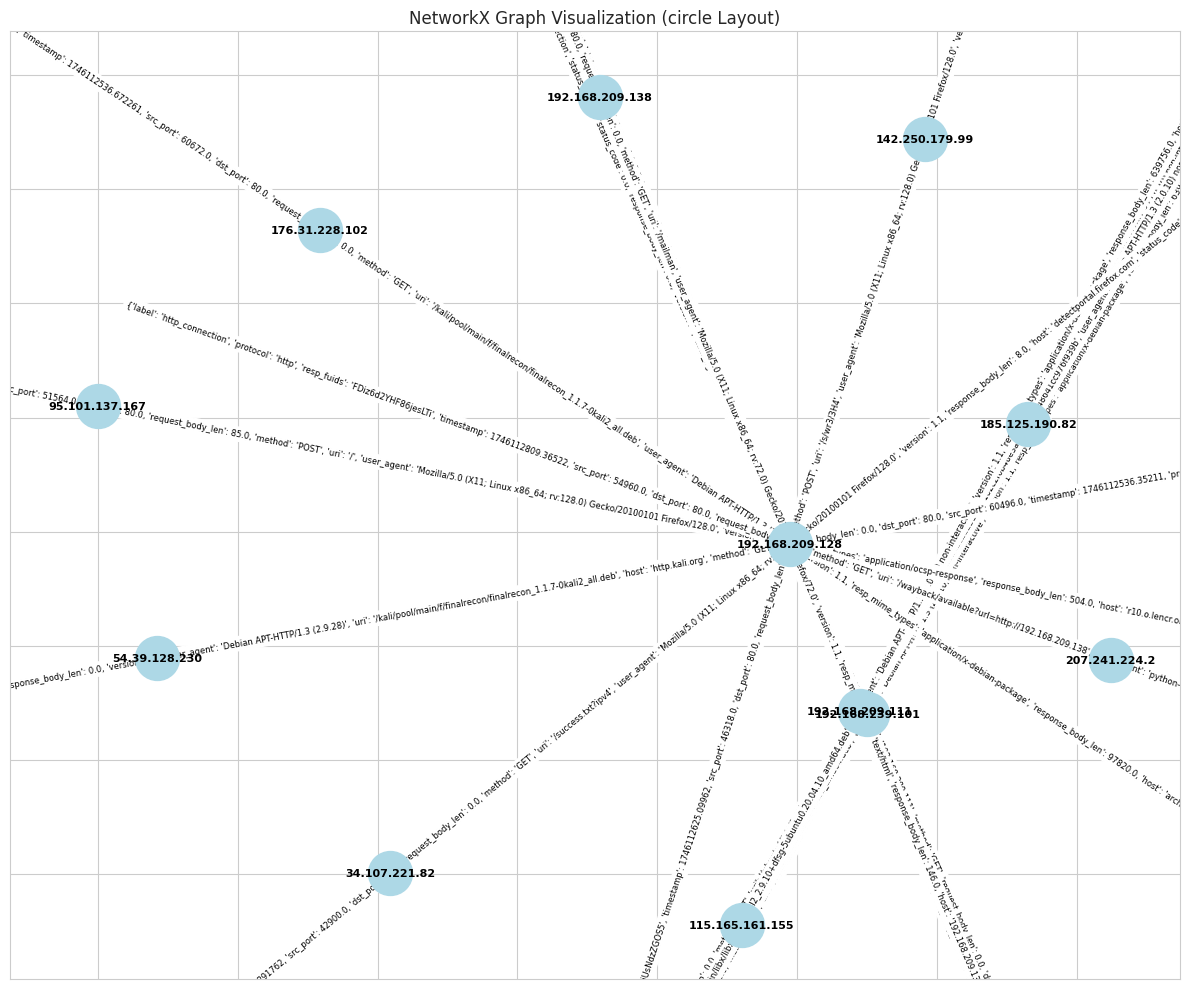

In [4]:
dot_file_path = "samples/sample_graph.dot"
layout_algorithm = "circle"
nx_graph = dot_to_nx(dot_file_path)

# Visualize the graph
visualize_nx_graph(nx_graph, layout_algorithm)

## Convert to PYG Graph

In [5]:
data = nx_to_pyg(nx_graph, node_scaling='standard', edge_scaling='standard')
print("\nPyTorch Geometric Data Object:")
print(data)

Sorted node attribute keys: ['activity_score', 'degree', 'in_degree', 'out_degree', 'total_connections']
Node Features (x) after initial standard scaling: tensor([[ 1.1130,  0.1744,  0.8979, -0.3022,  0.1744],
        [ 1.1130,  0.7701,  2.0513, -0.2984,  0.7701],
        [-1.0251, -0.5725, -0.5569, -0.3022, -0.5725],
        [ 0.8201, -0.5684, -0.5490, -0.3022, -0.5684],
        [ 1.1130,  0.7701,  2.0513, -0.2984,  0.7701],
        [-1.5231, -0.5729, -0.5578, -0.3022, -0.5729],
        [-0.4393, -0.5718, -0.5557, -0.3022, -0.5718],
        [-0.2929, -0.5716, -0.5553, -0.3022, -0.5716],
        [ 0.2929, -0.5705, -0.5532, -0.3022, -0.5705],
        [-1.0251, -0.5725, -0.5569, -0.3022, -0.5725],
        [-1.2595, -0.5727, -0.5574, -0.3022, -0.5727],
        [ 1.1130,  2.8582, -0.5582,  3.3166,  2.8582]])
Sorted edge attribute keys: ['dst_port', 'host', 'label', 'method', 'protocol', 'request_body_len', 'resp_fuids', 'resp_mime_types', 'response_body_len', 'src_port', 'status_code', 'st

In [6]:
# Add this code to explore the Data object:
print("\n--- Node Features (x) ---")
print(data.x)
print(f"Shape of node features: {data.x.shape}")


--- Node Features (x) ---
tensor([[ 1.1130,  0.1744,  0.8979, -0.3022,  0.1744],
        [ 1.1130,  0.7701,  2.0513, -0.2984,  0.7701],
        [-1.0251, -0.5725, -0.5569, -0.3022, -0.5725],
        [ 0.8201, -0.5684, -0.5490, -0.3022, -0.5684],
        [ 1.1130,  0.7701,  2.0513, -0.2984,  0.7701],
        [-1.5231, -0.5729, -0.5578, -0.3022, -0.5729],
        [-0.4393, -0.5718, -0.5557, -0.3022, -0.5718],
        [-0.2929, -0.5716, -0.5553, -0.3022, -0.5716],
        [ 0.2929, -0.5705, -0.5532, -0.3022, -0.5705],
        [-1.0251, -0.5725, -0.5569, -0.3022, -0.5725],
        [-1.2595, -0.5727, -0.5574, -0.3022, -0.5727],
        [ 1.1130,  2.8582, -0.5582,  3.3166,  2.8582]])
Shape of node features: torch.Size([12, 5])


In [7]:
print("\n--- Edge Indices (edge_index) ---")
print(data.edge_index)
print(f"Shape of edge indices: {data.edge_index.shape}")


--- Edge Indices (edge_index) ---
tensor([[ 1,  1,  1,  ..., 11, 11, 11],
        [ 8,  8,  8,  ...,  0,  0,  0]])
Shape of edge indices: torch.Size([2, 14384])


In [8]:
print("\n--- Edge Attributes (edge_attr) ---")
if data.edge_attr is not None:
    print(data.edge_attr)
    print(f"Shape of edge attributes: {data.edge_attr.shape}")
else:
    print("No edge attributes.")


--- Edge Attributes (edge_attr) ---
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0674],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0674],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0674],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0674],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0674],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0674]])
Shape of edge attributes: torch.Size([14384, 16])


# Feature visualization

Grafo con 12 nodi e 5 features:
Nomi features: activity_score, degree, in_degree, out_degree, total_connections

Statistiche features:
- activity_score: {'name': 'activity_score', 'unique': 8, 'mean': np.float32(-9.934108e-09), 'std': np.float32(0.99999994), 'min': np.float32(-1.523057), 'max': np.float32(1.1130031)}
- degree: {'name': 'degree', 'unique': 10, 'mean': np.float32(0.0), 'std': np.float32(1.0), 'min': np.float32(-0.5728879), 'max': np.float32(2.8582478)}
- in_degree: {'name': 'in_degree', 'unique': 10, 'mean': np.float32(0.0), 'std': np.float32(0.9999999), 'min': np.float32(-0.5581943), 'max': np.float32(2.0512643)}
- out_degree: {'name': 'out_degree', 'unique': 3, 'mean': np.float32(1.9868216e-08), 'std': np.float32(1.0), 'min': np.float32(-0.30220705), 'max': np.float32(3.3166215)}
- total_connections: {'name': 'total_connections', 'unique': 10, 'mean': np.float32(0.0), 'std': np.float32(1.0), 'min': np.float32(-0.5728879), 'max': np.float32(2.8582478)}


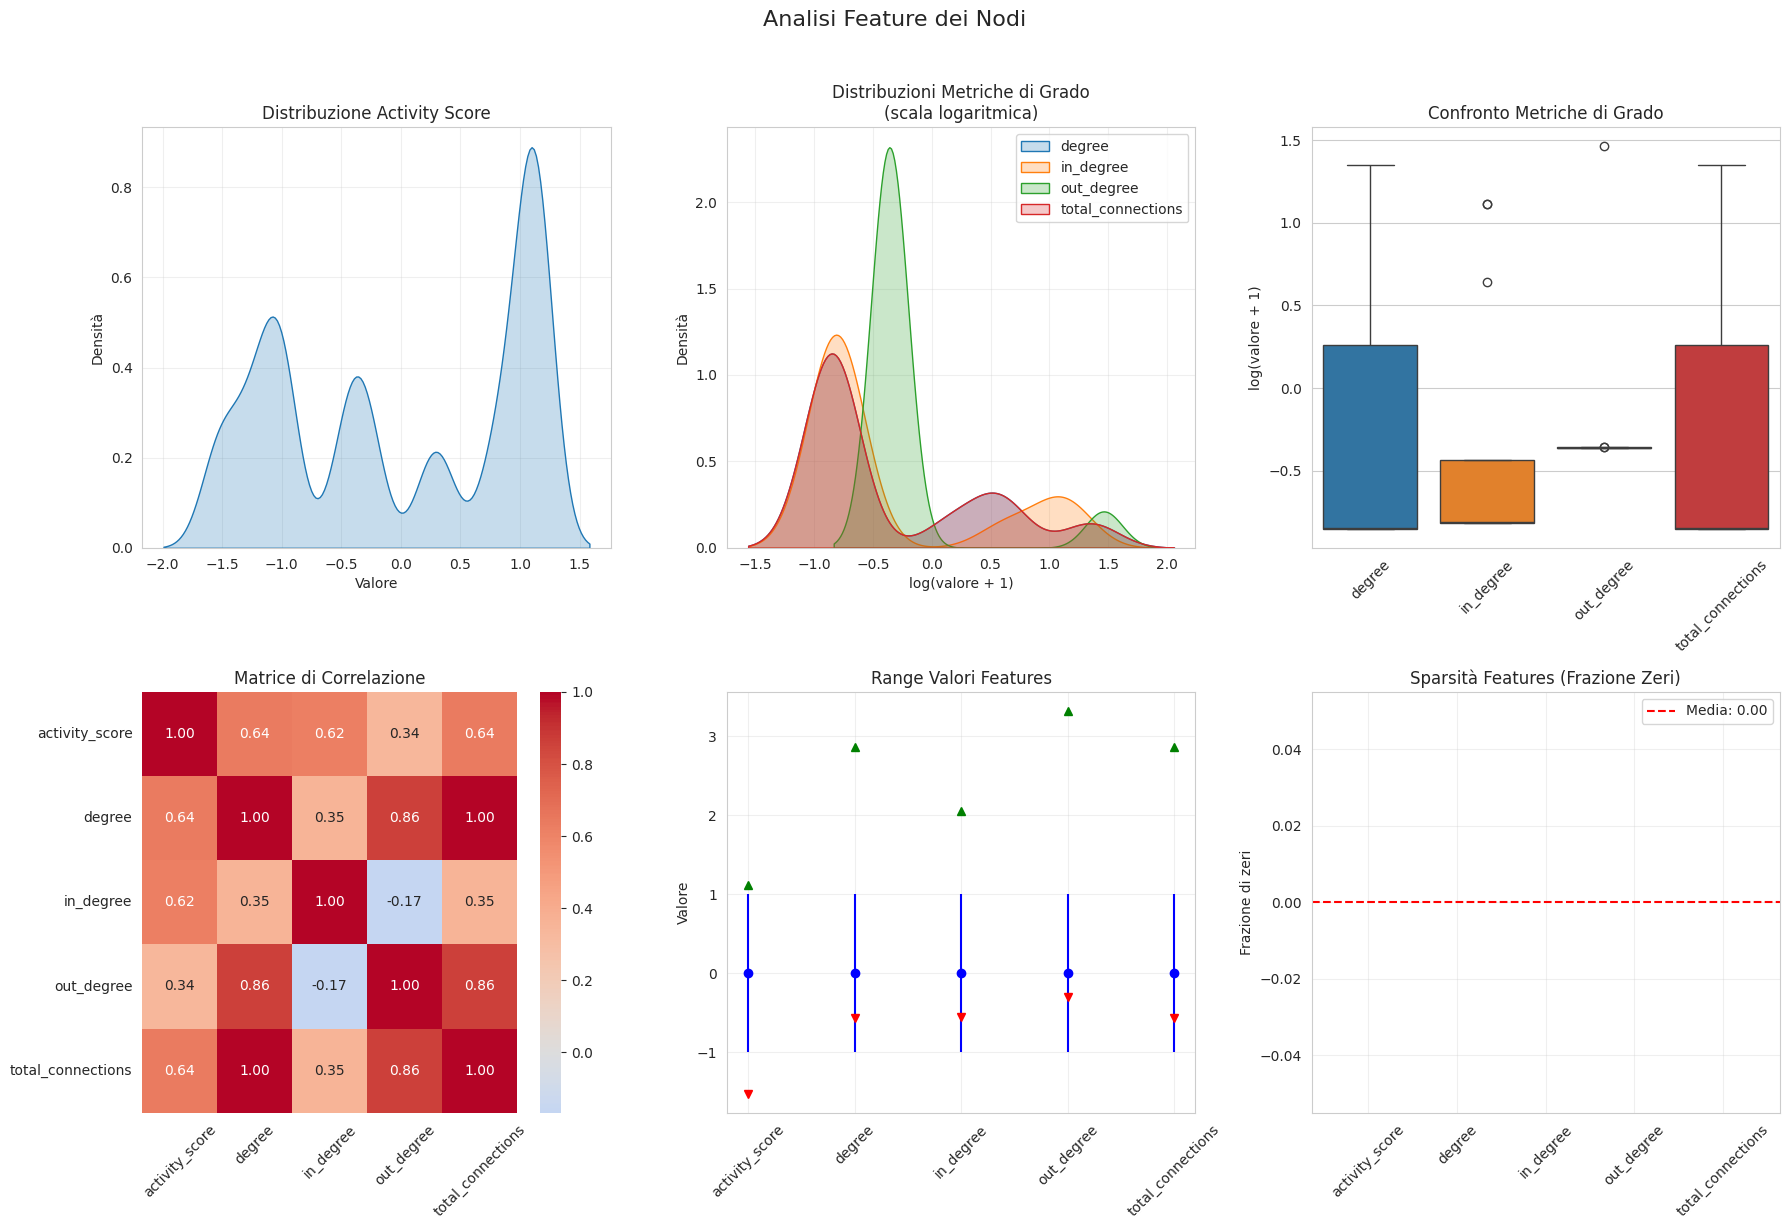


Analisi aggiuntiva:
- Le metriche di grado sono visualizzate in scala logaritmica
- Correlazione massima tra feature diverse: 1.00
- Correlazioni tra activity_score e metriche di grado:
  degree: 0.64
  in_degree: 0.62
  out_degree: 0.34
  total_connections: 0.64


In [9]:
feature_names = ['activity_score', 'degree', 'in_degree', 'out_degree', 'total_connections']
visualize_node_features(data, feature_names= feature_names)


# Import incremental graphs

In [10]:
# Load the initial graph
initial_graph = dot_to_nx("samples/initial_graph.dot")
data = nx_to_pyg(initial_graph, node_scaling='standard', edge_scaling='none')

Sorted node attribute keys: ['activity_score', 'degree', 'in_degree', 'out_degree', 'total_connections']
Node Features (x) after initial standard scaling: tensor([[-0.8888, -0.6990, -1.0000, -0.2402, -0.6990],
        [-0.8888, -0.6990, -0.6000, -0.4003, -0.6990],
        [ 0.5647,  0.1747,  1.4000, -0.4003,  0.1747],
        [ 0.7611,  0.3495,  1.8000, -0.4003,  0.3495],
        [-0.8888, -0.6990, -0.6000, -0.4003, -0.6990],
        [-0.2210, -0.3495,  0.2000, -0.4003, -0.3495],
        [-0.5352, -0.5242, -0.2000, -0.4003, -0.5242],
        [ 2.0968,  2.4464, -1.0000,  2.6421,  2.4464]])
Sorted edge attribute keys: ['dst_port', 'host', 'label', 'method', 'protocol', 'request_body_len', 'resp_fuids', 'resp_mime_types', 'response_body_len', 'src_port', 'status_code', 'status_msg', 'timestamp', 'uri', 'user_agent', 'version']
No edge feature scaling applied.


Grafo con 8 nodi e 5 features:
Nomi features: activity_score, degree, in_degree, out_degree, total_connections

Statistiche features:
- activity_score: {'name': 'activity_score', 'unique': 6, 'mean': np.float32(0.0), 'std': np.float32(1.0), 'min': np.float32(-0.8888047), 'max': np.float32(2.0967934)}
- degree: {'name': 'degree', 'unique': 6, 'mean': np.float32(7.450581e-09), 'std': np.float32(0.99999994), 'min': np.float32(-0.6989632), 'max': np.float32(2.4463713)}
- in_degree: {'name': 'in_degree', 'unique': 6, 'mean': np.float32(-4.4703484e-08), 'std': np.float32(0.99999994), 'min': np.float32(-1.0), 'max': np.float32(1.8)}
- out_degree: {'name': 'out_degree', 'unique': 3, 'mean': np.float32(2.9802322e-08), 'std': np.float32(1.0), 'min': np.float32(-0.40032038), 'max': np.float32(2.6421146)}
- total_connections: {'name': 'total_connections', 'unique': 6, 'mean': np.float32(7.450581e-09), 'std': np.float32(0.99999994), 'min': np.float32(-0.6989632), 'max': np.float32(2.4463713)}


/tmp/ipykernel_6164/2486239451.py:70: RuntimeWarning: divide by zero encountered in log1p
  log_vals = np.log1p(node_features[:, i])
/tmp/ipykernel_6164/2486239451.py:82: RuntimeWarning: divide by zero encountered in log1p
  log_data = np.log1p(node_features[:, degree_features])


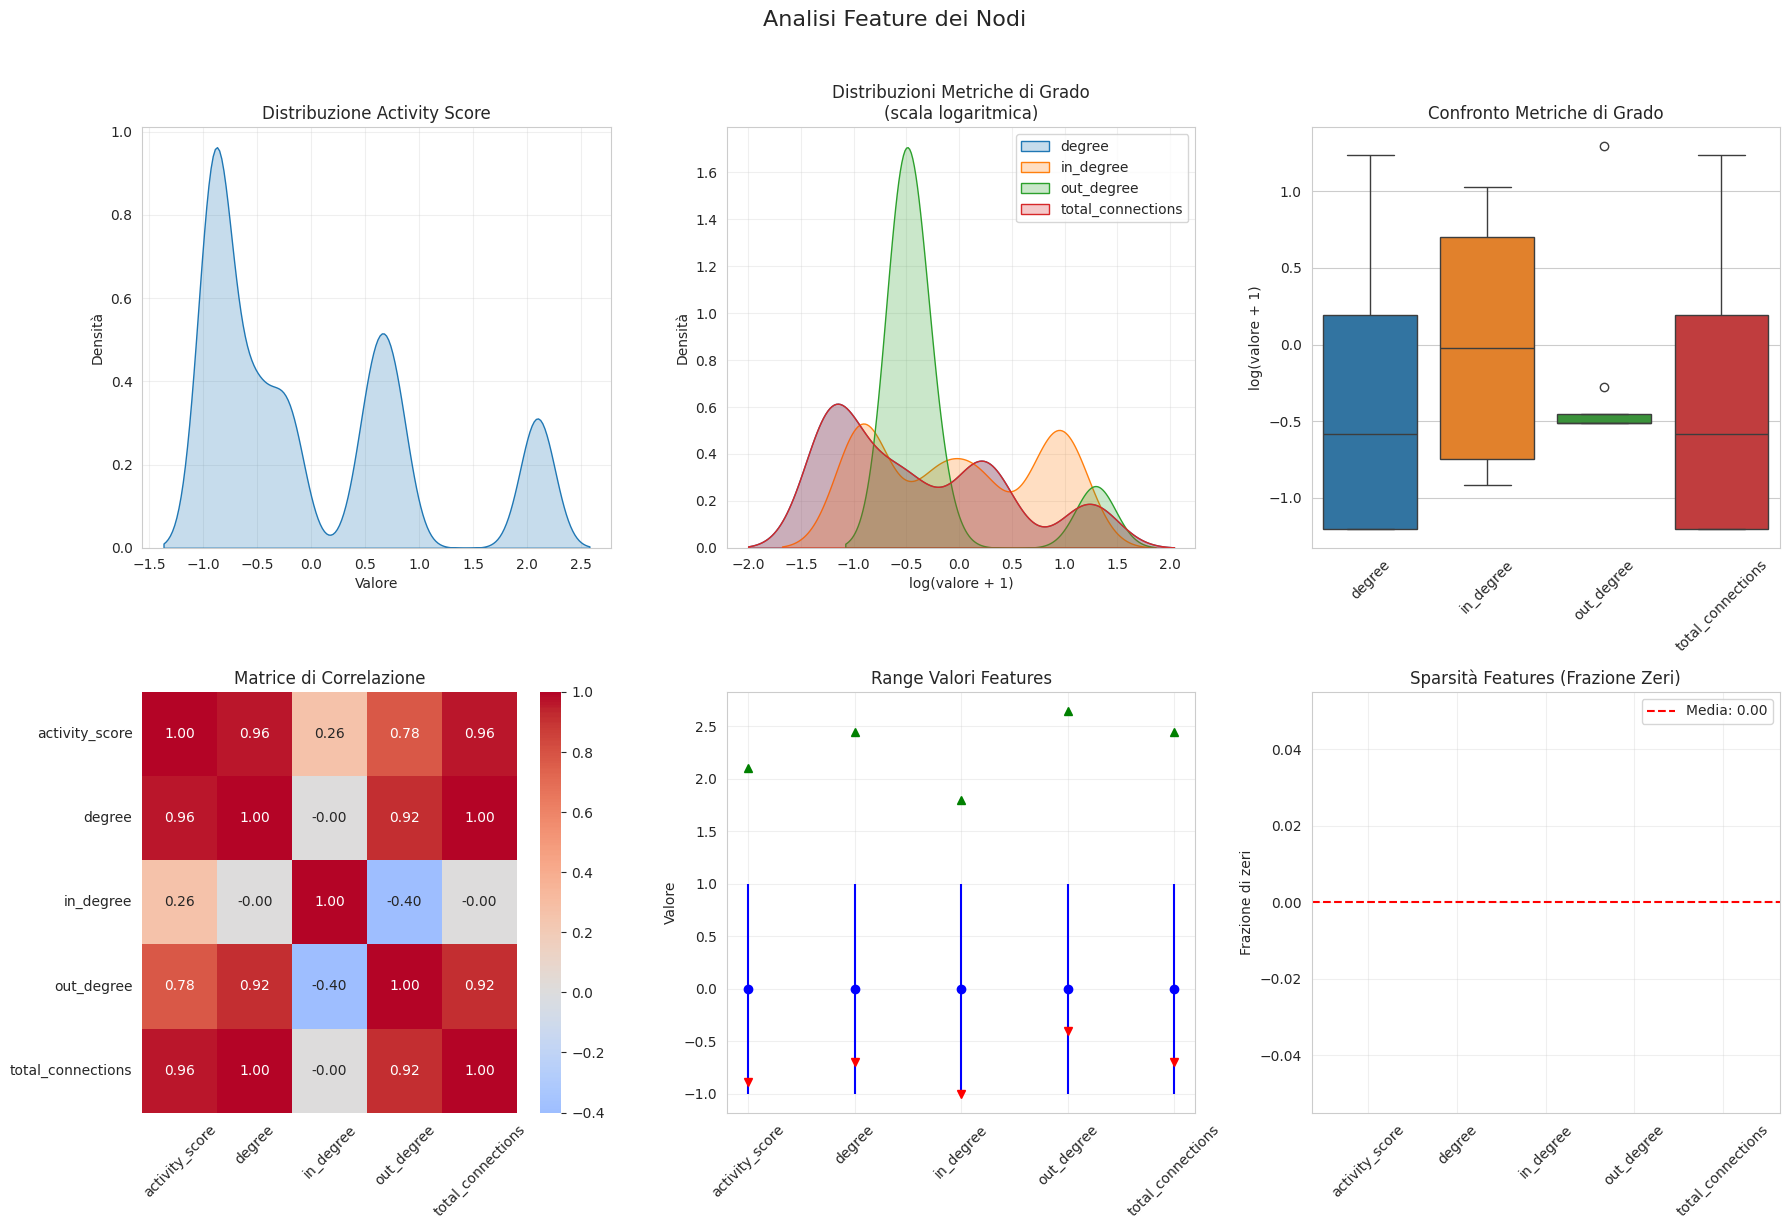


Analisi aggiuntiva:
- Le metriche di grado sono visualizzate in scala logaritmica
- Correlazione massima tra feature diverse: 1.00
- Correlazioni tra activity_score e metriche di grado:
  degree: 0.96
  in_degree: 0.26
  out_degree: 0.78
  total_connections: 0.96


In [11]:
feature_names = ['activity_score', 'degree', 'in_degree', 'out_degree', 'total_connections']
visualize_node_features(data, feature_names= feature_names)

In [ ]:
edge_features_name = ['dst_port', 'host', 'label', 'method', 'protocol', 'request_body_len', 'resp_fuids', 'resp_mime_types', 'response_body_len', 'src_port', 'status_code', 'status_msg', 'timestamp', 'uri', 'user_agent', 'version']
visualize_edge_features(data, edge_features_name)

Grafo con 20 archi e 16 edge features:

Statistiche edge features:
- dst_port: {'name': 'dst_port', 'unique': 1, 'mean': np.float32(80.0), 'std': np.float32(0.0), 'min': np.float32(80.0), 'max': np.float32(80.0)}
- host: {'name': 'host', 'unique': 1, 'mean': np.float32(0.0), 'std': np.float32(0.0), 'min': np.float32(0.0), 'max': np.float32(0.0)}
- label: {'name': 'label', 'unique': 1, 'mean': np.float32(0.0), 'std': np.float32(0.0), 'min': np.float32(0.0), 'max': np.float32(0.0)}
- method: {'name': 'method', 'unique': 1, 'mean': np.float32(0.0), 'std': np.float32(0.0), 'min': np.float32(0.0), 'max': np.float32(0.0)}
- protocol: {'name': 'protocol', 'unique': 1, 'mean': np.float32(0.0), 'std': np.float32(0.0), 'min': np.float32(0.0), 'max': np.float32(0.0)}
- status_msg: {'name': 'status_msg', 'unique': 1, 'mean': np.float32(0.0), 'std': np.float32(0.0), 'min': np.float32(0.0), 'max': np.float32(0.0)}
- timestamp: {'name': 'timestamp', 'unique': 3, 'mean': np.float32(1746112500.0), 'std

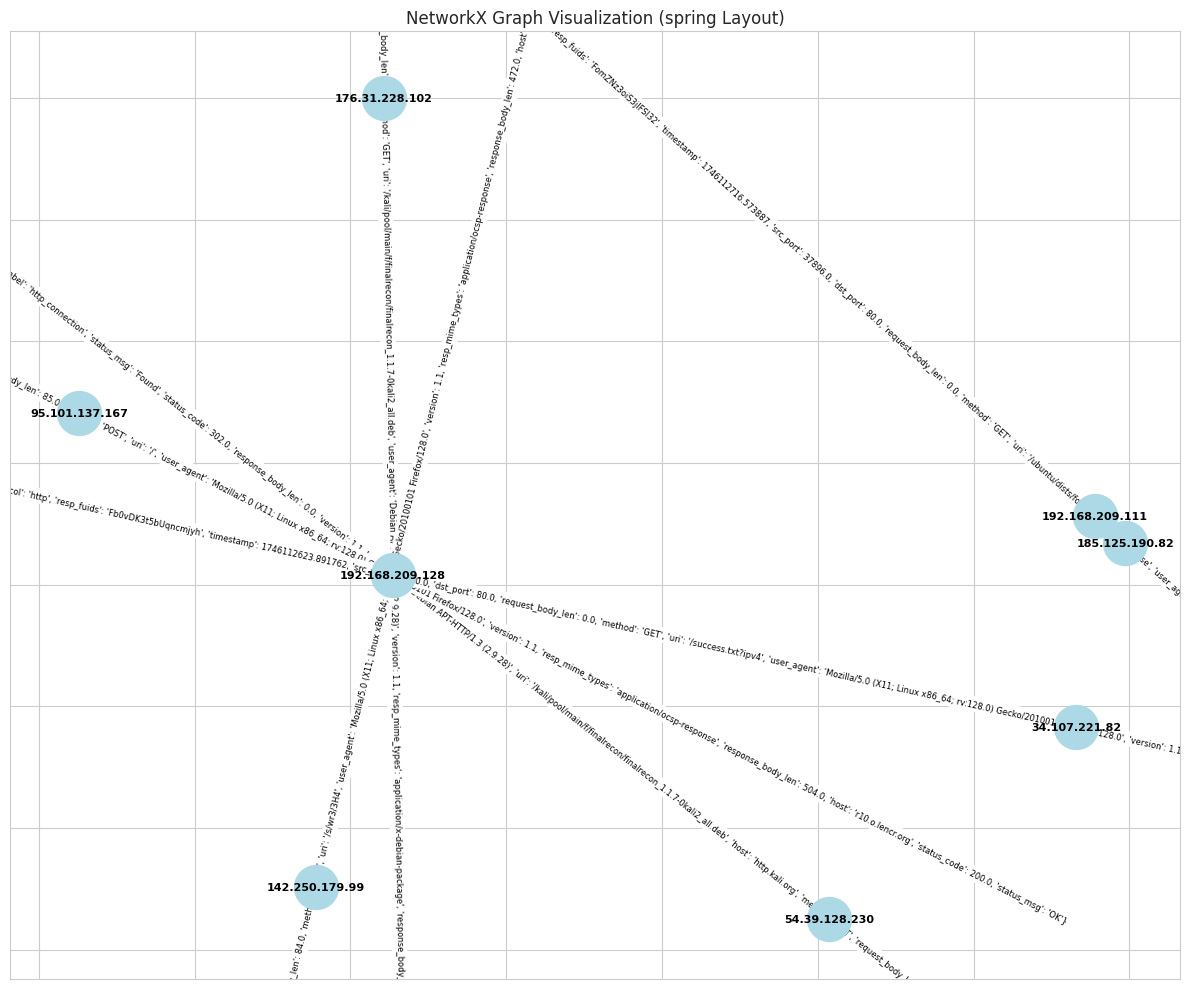

In [12]:
visualize_nx_graph(initial_graph)

In [13]:
 # Update the graph
updated_graph = update_nx_graph(initial_graph, "samples/update_graph_1.dot")
data = nx_to_pyg(updated_graph, node_scaling='standard', edge_scaling='standard')

Updated node: 192.168.209.128
Updated node: 54.39.128.230
Updated node: 176.31.228.102
Updated node: 95.101.137.167
Updated node: 142.250.179.99
Updated node: 34.107.221.82
Updated node: 192.168.209.111
Updated node: 185.125.190.82
Added node: 192.168.239.101
Added node: 115.165.161.155
Added edge: 192.168.209.128 -> 54.39.128.230, key=0
Added edge: 192.168.209.128 -> 54.39.128.230, key=1
Added edge: 192.168.209.128 -> 176.31.228.102, key=0
Added edge: 192.168.209.128 -> 176.31.228.102, key=1
Added edge: 192.168.209.128 -> 176.31.228.102, key=2
Added edge: 192.168.209.128 -> 95.101.137.167, key=0
Added edge: 192.168.209.128 -> 95.101.137.167, key=1
Added edge: 192.168.209.128 -> 95.101.137.167, key=2
Added edge: 192.168.209.128 -> 95.101.137.167, key=3
Added edge: 192.168.209.128 -> 95.101.137.167, key=4
Added edge: 192.168.209.128 -> 95.101.137.167, key=5
Added edge: 192.168.209.128 -> 95.101.137.167, key=6
Added edge: 192.168.209.128 -> 142.250.179.99, key=0
Added edge: 192.168.209.1

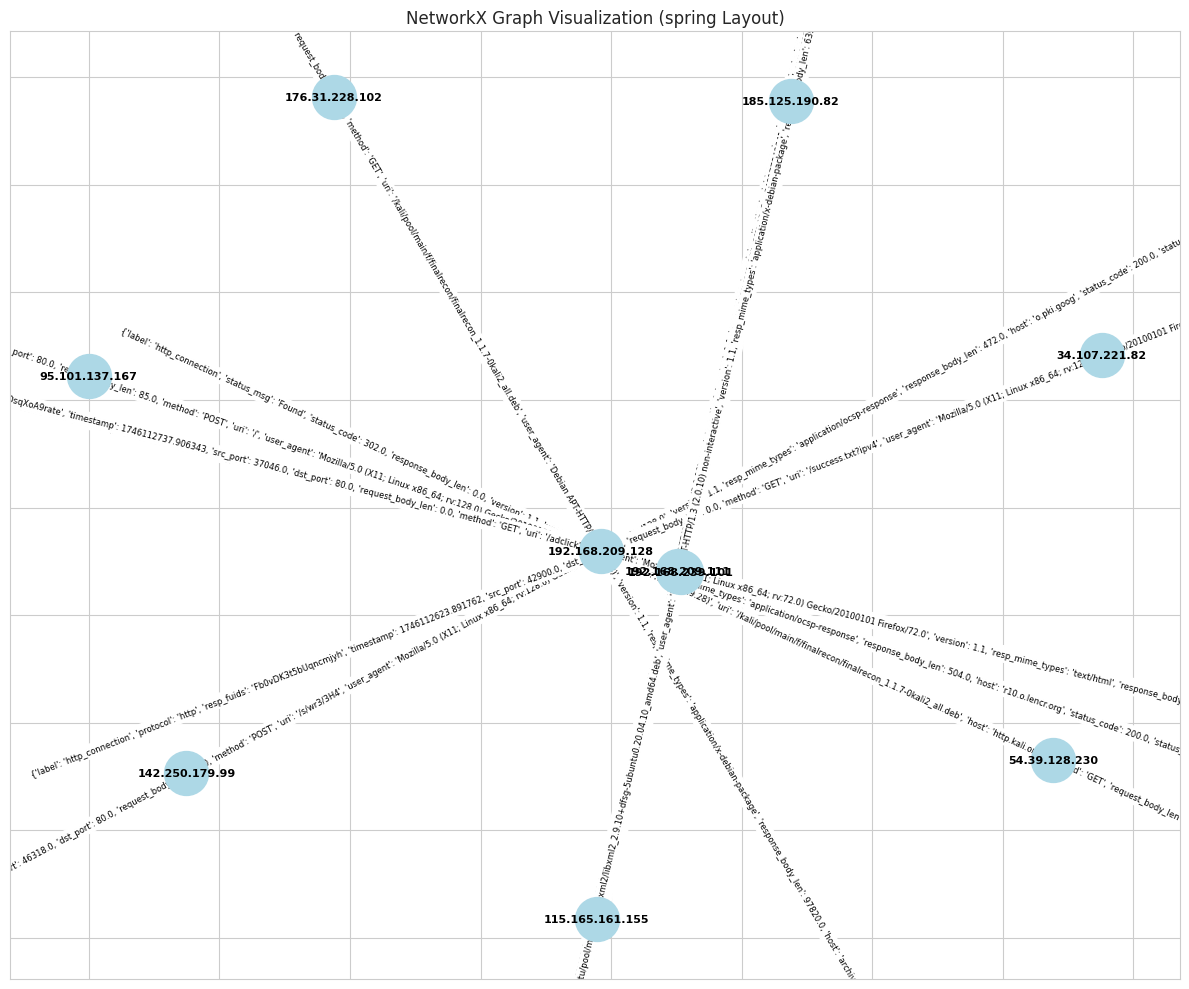

In [14]:
visualize_nx_graph(updated_graph)

Grafo con 10 nodi e 5 features:
Nomi features: activity_score, degree, in_degree, out_degree, total_connections

Statistiche features:
- activity_score: {'name': 'activity_score', 'unique': 8, 'mean': np.float32(5.9604646e-09), 'std': np.float32(1.0), 'min': np.float32(-1.9027016), 'max': np.float32(1.0384974)}
- degree: {'name': 'degree', 'unique': 10, 'mean': np.float32(-1.1920929e-08), 'std': np.float32(1.0), 'min': np.float32(-0.65169746), 'max': np.float32(2.437273)}
- in_degree: {'name': 'in_degree', 'unique': 9, 'mean': np.float32(8.940697e-09), 'std': np.float32(0.99999994), 'min': np.float32(-0.6027227), 'max': np.float32(1.9950235)}
- out_degree: {'name': 'out_degree', 'unique': 4, 'mean': np.float32(2.9802323e-09), 'std': np.float32(1.0), 'min': np.float32(-0.3593862), 'max': np.float32(2.9966967)}
- total_connections: {'name': 'total_connections', 'unique': 10, 'mean': np.float32(-1.1920929e-08), 'std': np.float32(1.0), 'min': np.float32(-0.65169746), 'max': np.float32(2.43

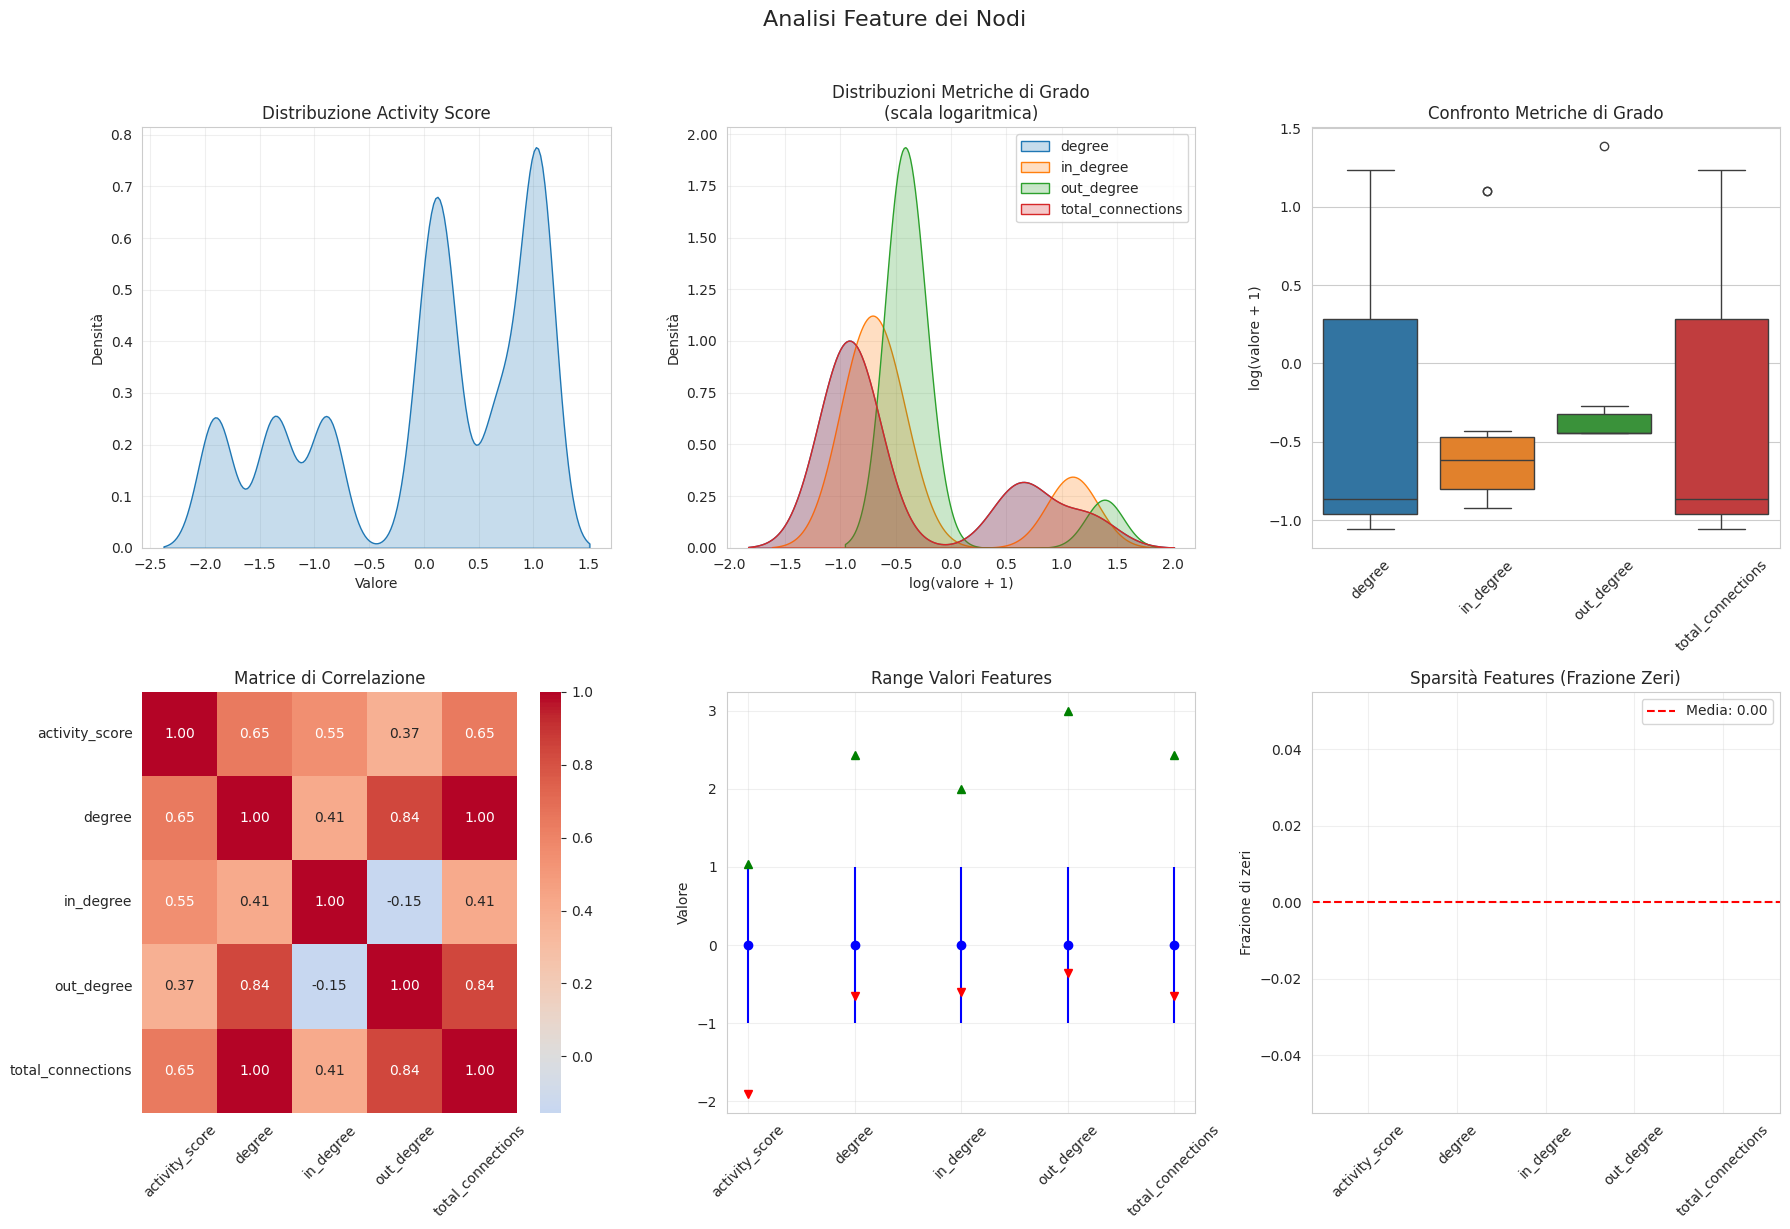


Analisi aggiuntiva:
- Le metriche di grado sono visualizzate in scala logaritmica
- Correlazione massima tra feature diverse: 1.00
- Correlazioni tra activity_score e metriche di grado:
  degree: 0.65
  in_degree: 0.55
  out_degree: 0.37
  total_connections: 0.65


In [15]:
visualize_node_features(data, feature_names= feature_names)

Grafo con 509 archi e 16 edge features:

Statistiche edge features:
- EdgeFeat_0: {'name': 'EdgeFeat_0', 'unique': 1, 'mean': np.float32(0.0), 'std': np.float32(0.0), 'min': np.float32(0.0), 'max': np.float32(0.0)}
- EdgeFeat_1: {'name': 'EdgeFeat_1', 'unique': 1, 'mean': np.float32(0.0), 'std': np.float32(0.0), 'min': np.float32(0.0), 'max': np.float32(0.0)}
- EdgeFeat_2: {'name': 'EdgeFeat_2', 'unique': 1, 'mean': np.float32(0.0), 'std': np.float32(0.0), 'min': np.float32(0.0), 'max': np.float32(0.0)}
- EdgeFeat_3: {'name': 'EdgeFeat_3', 'unique': 1, 'mean': np.float32(0.0), 'std': np.float32(0.0), 'min': np.float32(0.0), 'max': np.float32(0.0)}
- EdgeFeat_4: {'name': 'EdgeFeat_4', 'unique': 1, 'mean': np.float32(0.0), 'std': np.float32(0.0), 'min': np.float32(0.0), 'max': np.float32(0.0)}
- EdgeFeat_11: {'name': 'EdgeFeat_11', 'unique': 1, 'mean': np.float32(0.0), 'std': np.float32(0.0), 'min': np.float32(0.0), 'max': np.float32(0.0)}
- EdgeFeat_12: {'name': 'EdgeFeat_12', 'unique':

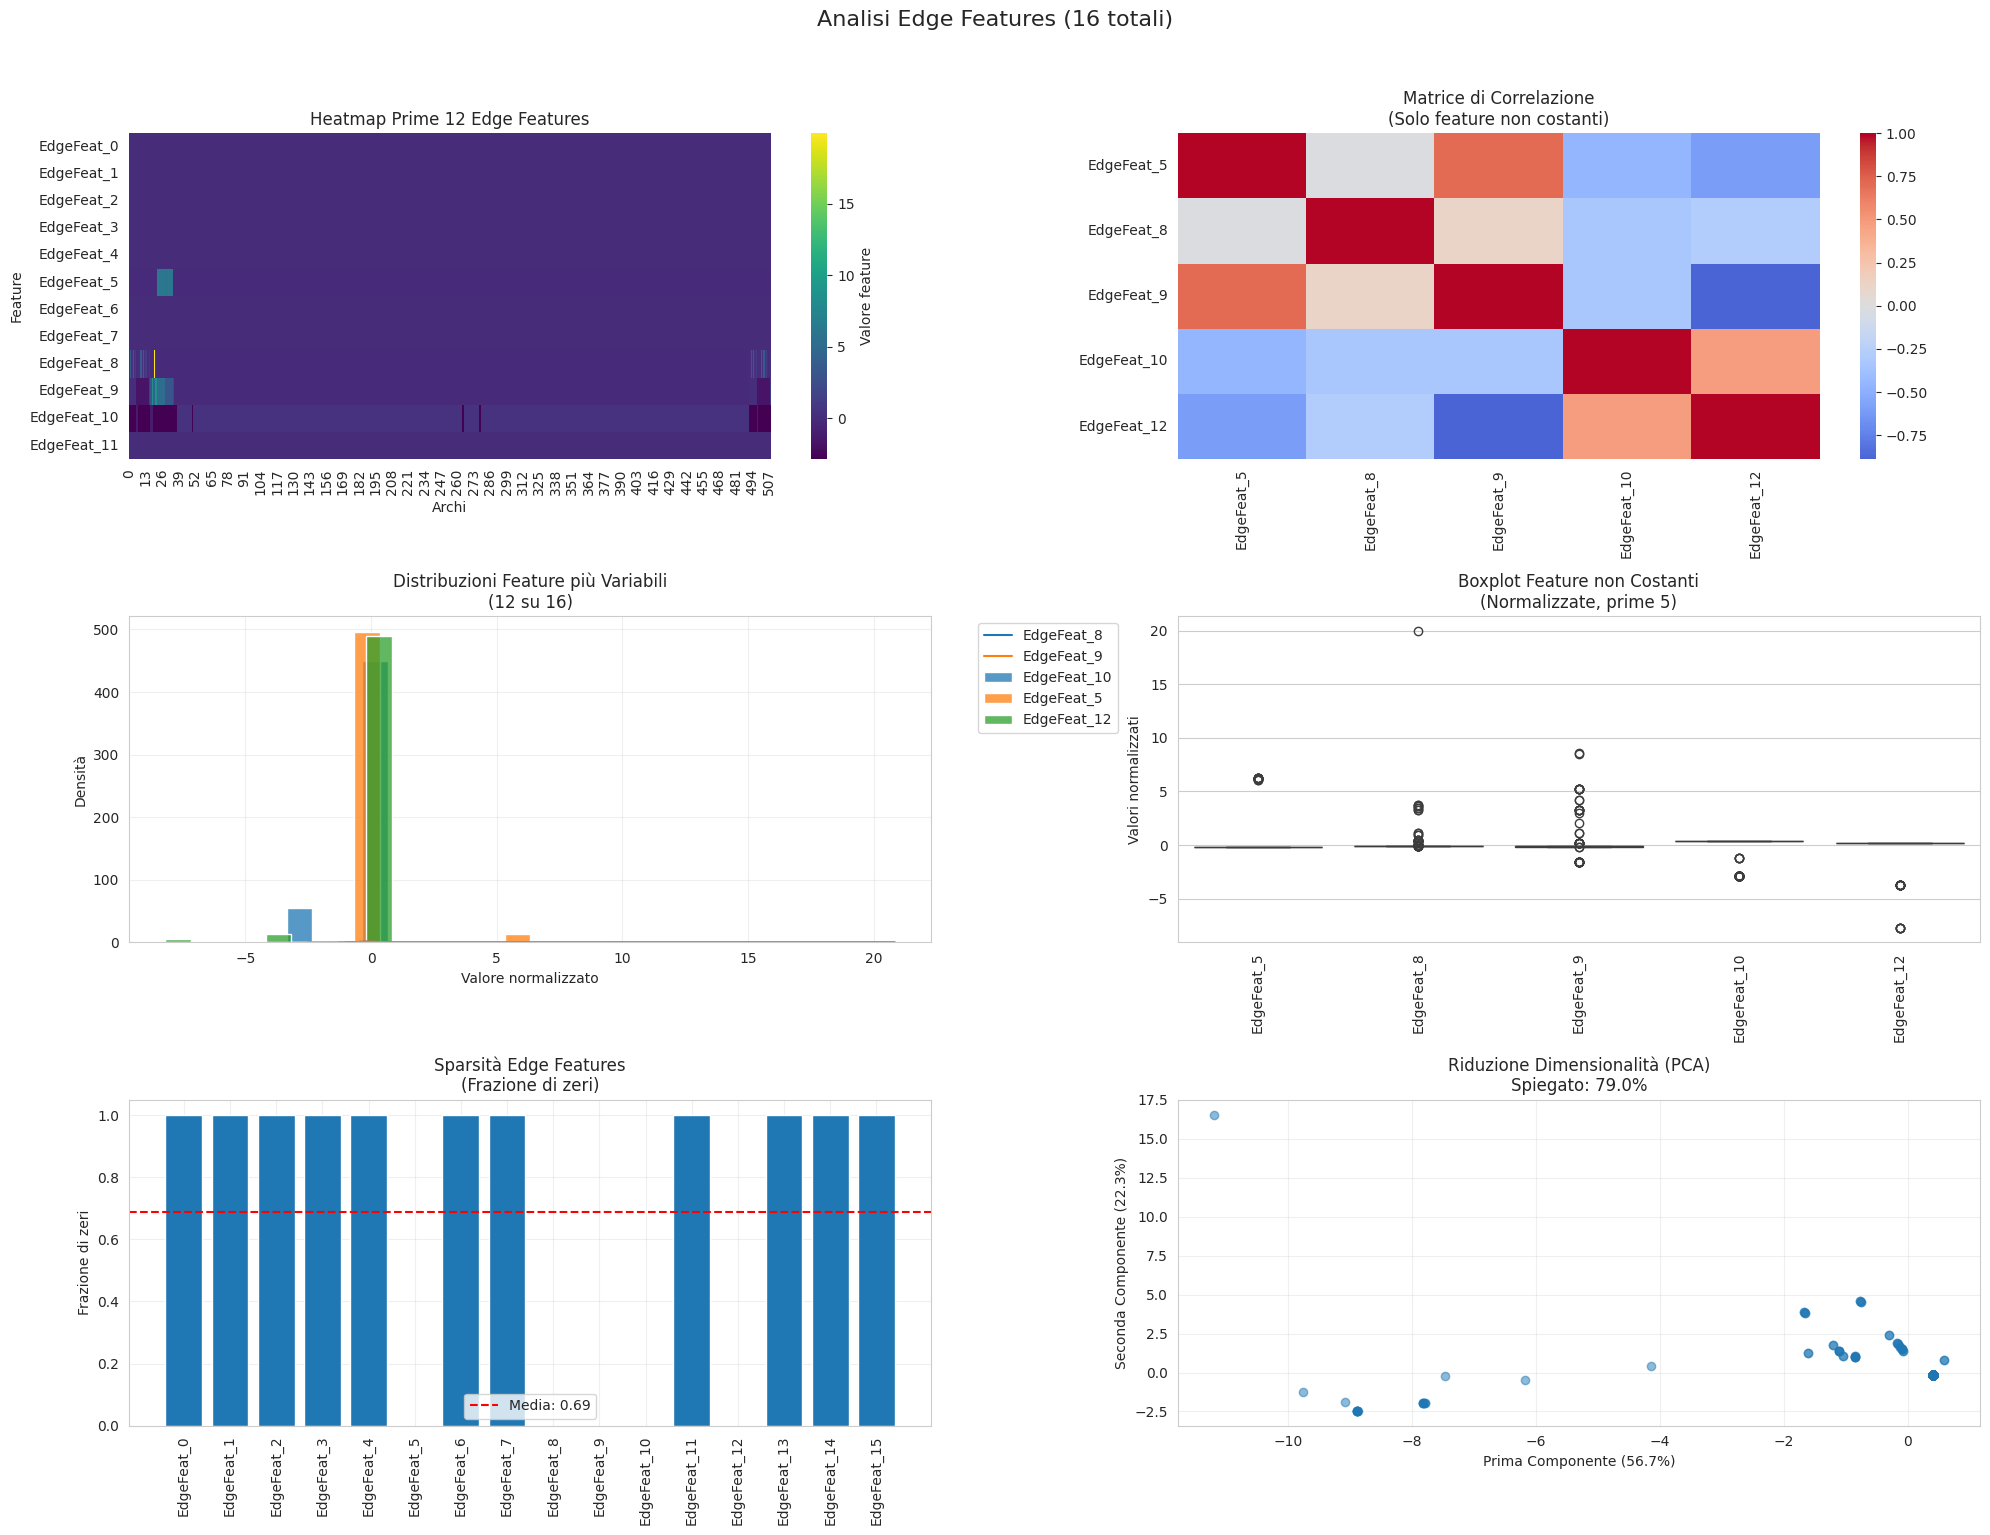


Analisi aggiuntiva:
- 11 feature sono costanti
- Massima correlazione tra feature diverse: 0.89
- Feature più correlate: EdgeFeat_9 e EdgeFeat_12 (0.89)


In [56]:
visualize_edge_features(data)

In [57]:
updated_graph = update_nx_graph(updated_graph, "samples/update_graph_2.dot")
data = nx_to_pyg(updated_graph, node_scaling='standard', edge_scaling='standard')

Updated node: 192.168.209.128
Updated node: 54.39.128.230
Updated node: 176.31.228.102
Updated node: 95.101.137.167
Updated node: 142.250.179.99
Updated node: 34.107.221.82
Updated node: 192.168.209.111
Updated node: 185.125.190.82
Updated node: 192.168.239.101
Updated node: 115.165.161.155
Added edge: 192.168.209.128 -> 54.39.128.230, key=0
Added edge: 192.168.209.128 -> 54.39.128.230, key=1
Added edge: 192.168.209.128 -> 176.31.228.102, key=0
Added edge: 192.168.209.128 -> 176.31.228.102, key=1
Added edge: 192.168.209.128 -> 176.31.228.102, key=2
Added edge: 192.168.209.128 -> 95.101.137.167, key=0
Added edge: 192.168.209.128 -> 95.101.137.167, key=1
Added edge: 192.168.209.128 -> 95.101.137.167, key=2
Added edge: 192.168.209.128 -> 95.101.137.167, key=3
Added edge: 192.168.209.128 -> 95.101.137.167, key=4
Added edge: 192.168.209.128 -> 95.101.137.167, key=5
Added edge: 192.168.209.128 -> 95.101.137.167, key=6
Added edge: 192.168.209.128 -> 142.250.179.99, key=0
Added edge: 192.168.2

Grafo con 10 nodi e 5 features:
Nomi features: activity_score, degree, in_degree, out_degree, total_connections

Statistiche features:
- activity_score: {'name': 'activity_score', 'unique': 8, 'mean': np.float32(5.9604646e-09), 'std': np.float32(1.0), 'min': np.float32(-2.1508555), 'max': np.float32(0.8060645)}
- degree: {'name': 'degree', 'unique': 10, 'mean': np.float32(-1.7881394e-08), 'std': np.float32(0.99999994), 'min': np.float32(-0.6220558), 'max': np.float32(2.4143233)}
- in_degree: {'name': 'in_degree', 'unique': 9, 'mean': np.float32(-8.940697e-09), 'std': np.float32(1.0), 'min': np.float32(-0.5347066), 'max': np.float32(1.9992799)}
- out_degree: {'name': 'out_degree', 'unique': 4, 'mean': np.float32(-1.1920929e-08), 'std': np.float32(1.0), 'min': np.float32(-0.34420216), 'max': np.float32(2.9994352)}
- total_connections: {'name': 'total_connections', 'unique': 10, 'mean': np.float32(-1.7881394e-08), 'std': np.float32(0.99999994), 'min': np.float32(-0.6220558), 'max': np.flo

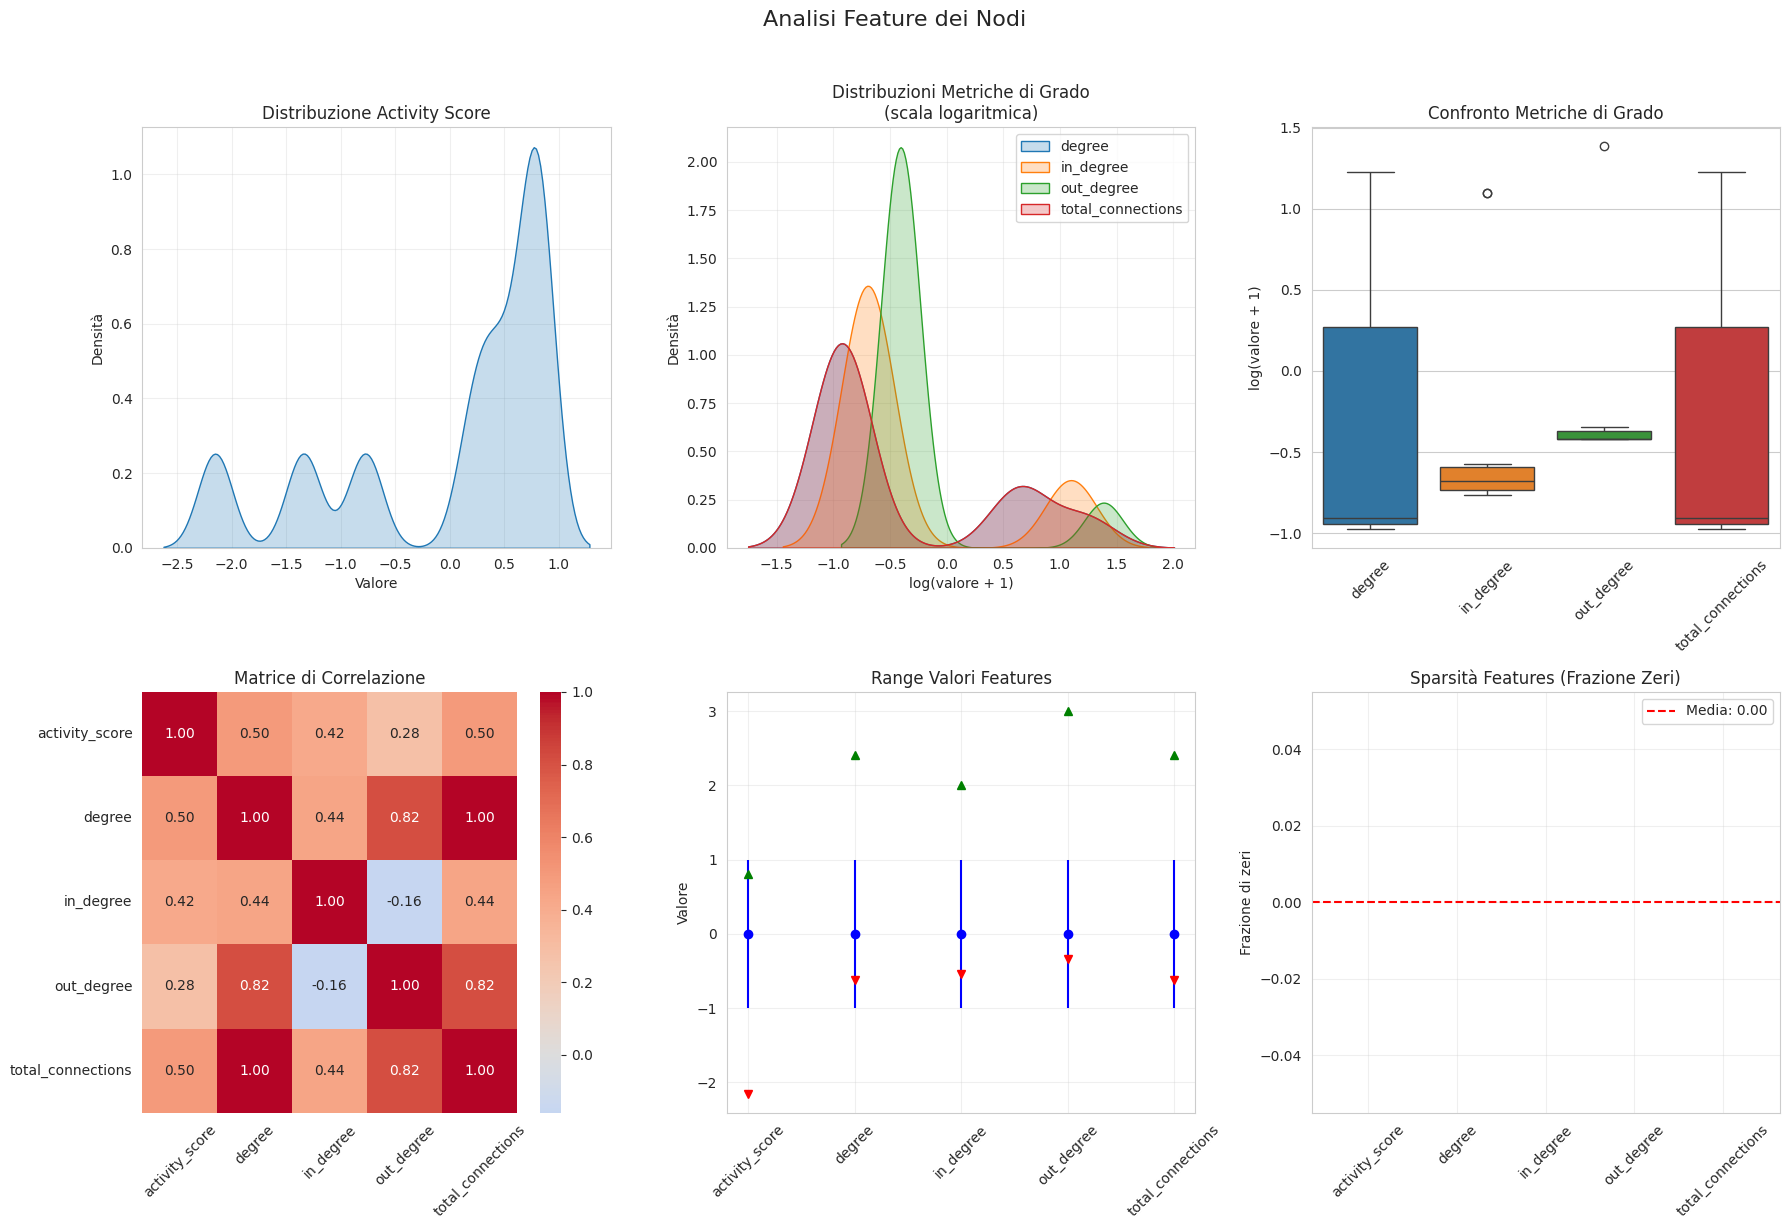


Analisi aggiuntiva:
- Le metriche di grado sono visualizzate in scala logaritmica
- Correlazione massima tra feature diverse: 1.00
- Correlazioni tra activity_score e metriche di grado:
  degree: 0.50
  in_degree: 0.42
  out_degree: 0.28
  total_connections: 0.50


In [58]:
visualize_node_features(data, feature_names= feature_names)

Grafo con 1885 archi e 16 edge features:

Statistiche edge features:
- EdgeFeat_0: {'name': 'EdgeFeat_0', 'unique': 1, 'mean': np.float32(0.0), 'std': np.float32(0.0), 'min': np.float32(0.0), 'max': np.float32(0.0)}
- EdgeFeat_1: {'name': 'EdgeFeat_1', 'unique': 1, 'mean': np.float32(0.0), 'std': np.float32(0.0), 'min': np.float32(0.0), 'max': np.float32(0.0)}
- EdgeFeat_2: {'name': 'EdgeFeat_2', 'unique': 1, 'mean': np.float32(0.0), 'std': np.float32(0.0), 'min': np.float32(0.0), 'max': np.float32(0.0)}
- EdgeFeat_3: {'name': 'EdgeFeat_3', 'unique': 1, 'mean': np.float32(0.0), 'std': np.float32(0.0), 'min': np.float32(0.0), 'max': np.float32(0.0)}
- EdgeFeat_4: {'name': 'EdgeFeat_4', 'unique': 1, 'mean': np.float32(0.0), 'std': np.float32(0.0), 'min': np.float32(0.0), 'max': np.float32(0.0)}
- EdgeFeat_11: {'name': 'EdgeFeat_11', 'unique': 1, 'mean': np.float32(0.0), 'std': np.float32(0.0), 'min': np.float32(0.0), 'max': np.float32(0.0)}
- EdgeFeat_12: {'name': 'EdgeFeat_12', 'unique'

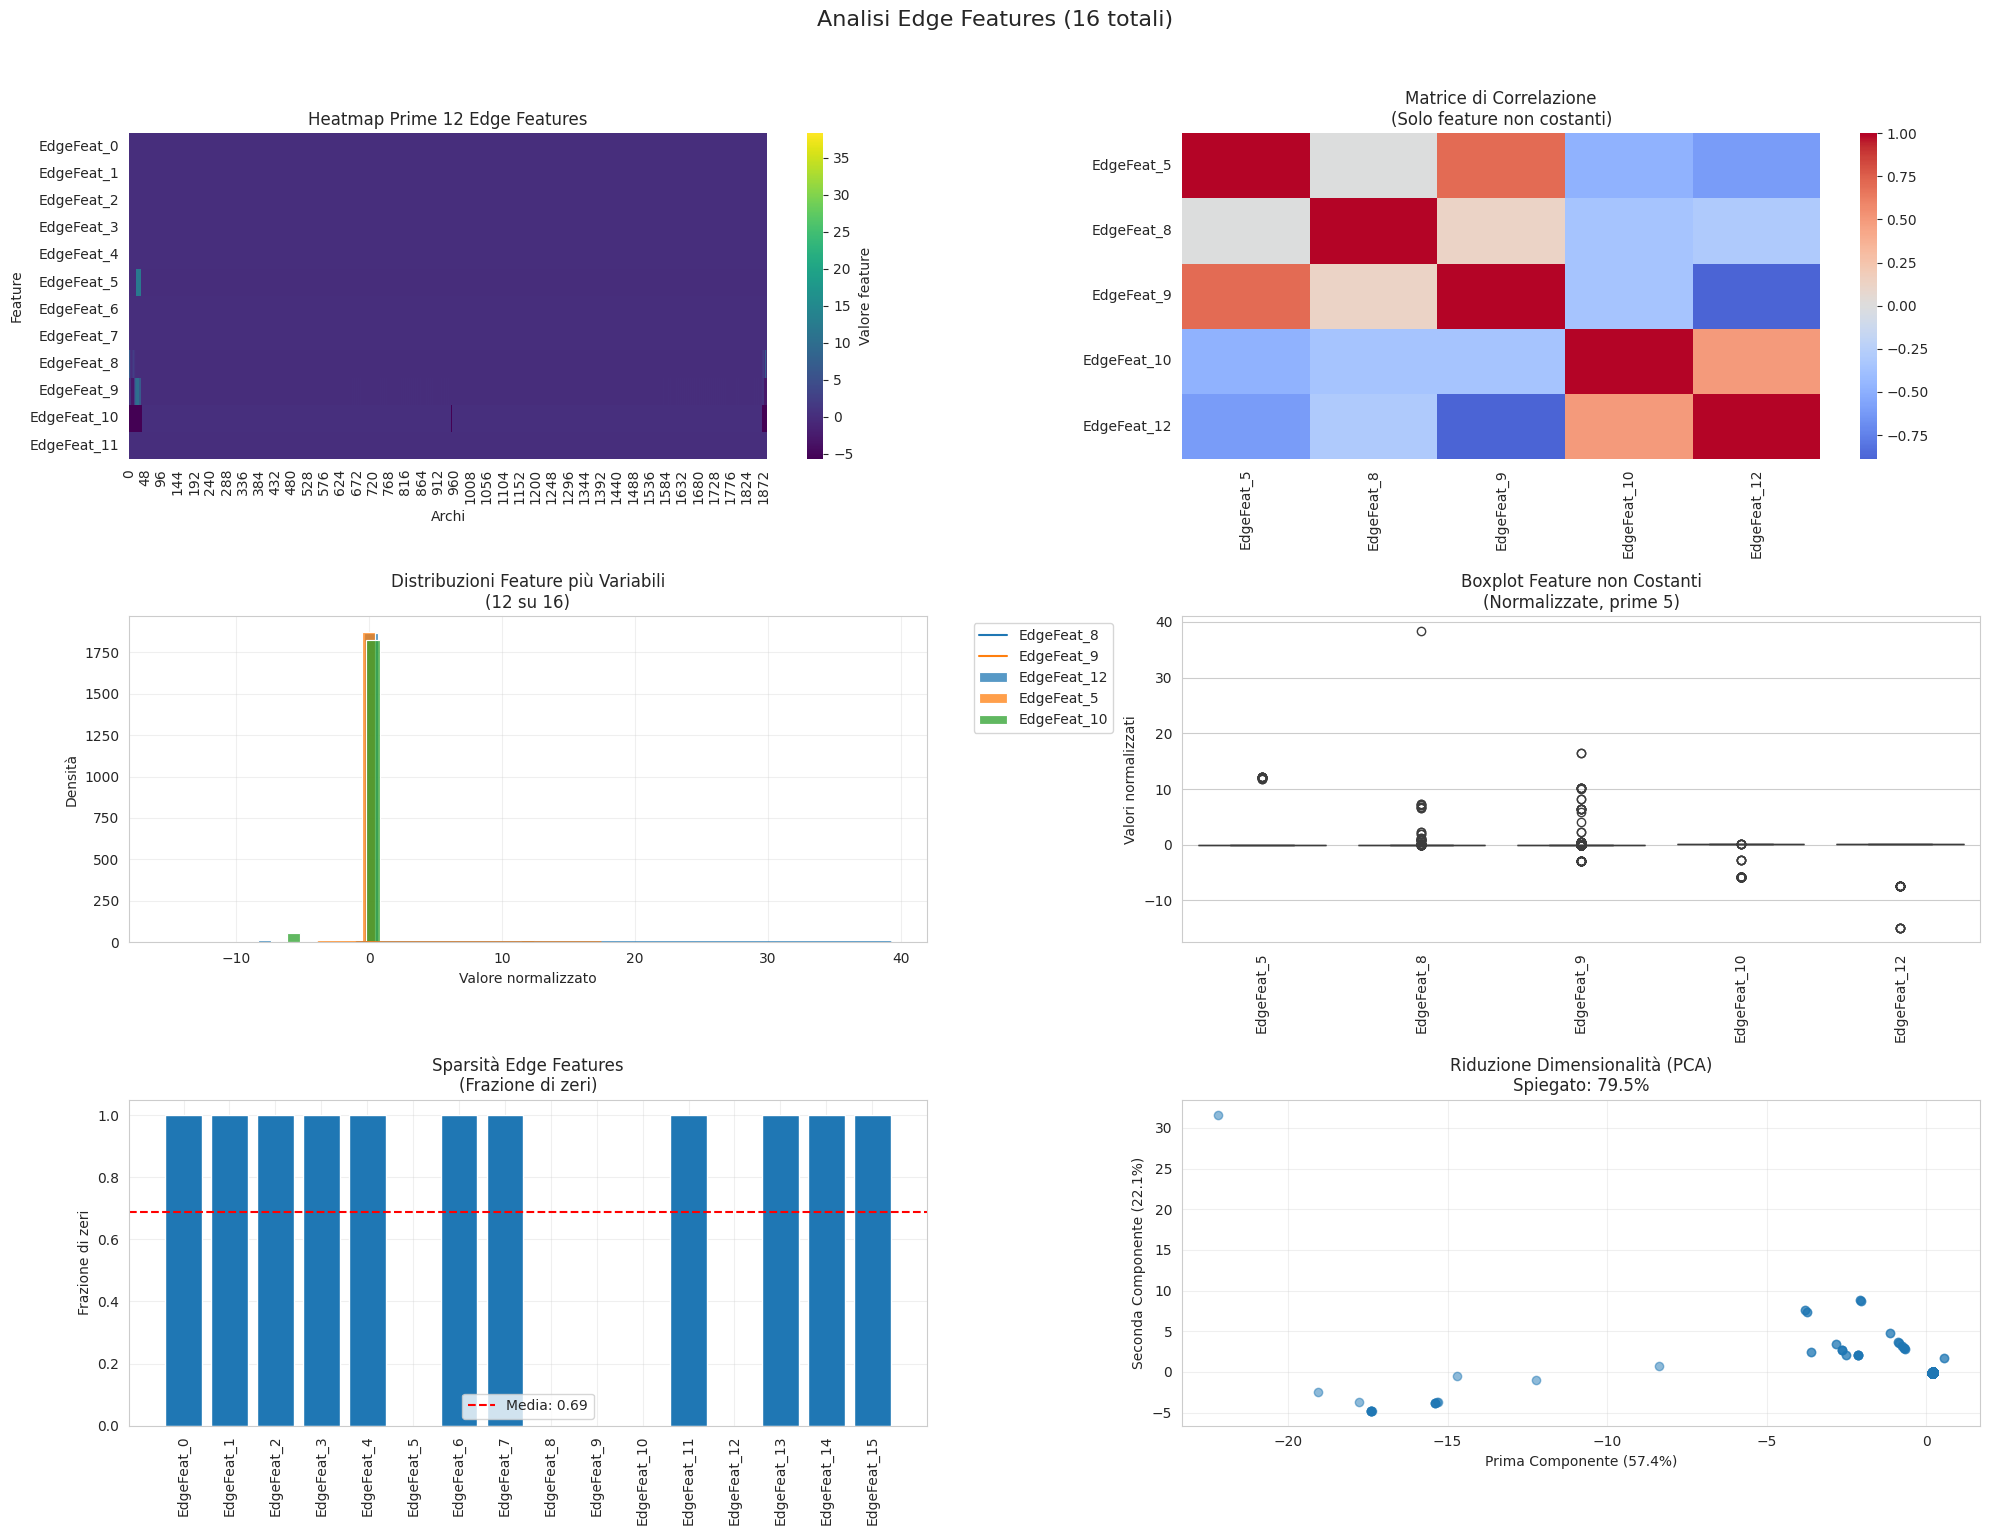


Analisi aggiuntiva:
- 11 feature sono costanti
- Massima correlazione tra feature diverse: 0.89
- Feature più correlate: EdgeFeat_9 e EdgeFeat_12 (0.89)


In [59]:
visualize_edge_features(data)